In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SBBBBBBS'
m='TMIN'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
data_dir='../../Data/Weather'
file_index='SBBBBBBS'

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    35|[70 DA 00 7E 00 7...|1904.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    30|[80 D4 F0 DA F0 D...|1905.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    18|[70 DA 28 D8 E0 D...|1906.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    28|[E8 D9 F0 D6 78 D...|1907.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    22|[00 7E 00 7E 00 7...|1908.0|SBBBBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [8]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(2254L, 365L)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

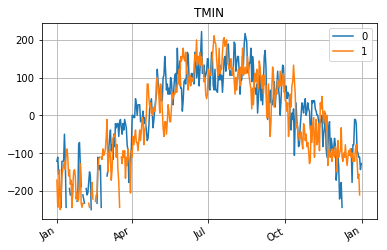

In [9]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

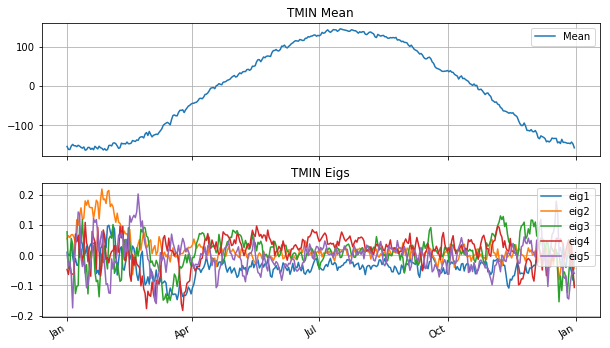

In [14]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=5
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

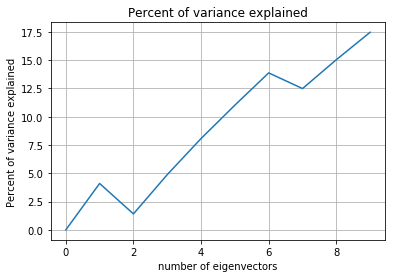

In [15]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [38]:
i=10
v=[np.array(EigVec[:,j]).flatten() for j in range(shape(EigVec)[1])]
print i
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

10
residual normalized norm  after mean: 0.167258730358
residual normalized norm  after mean + top eigs: [ 0.92017835  1.00108544  0.9798276   0.97982743  0.9776628 ]


In [42]:
coeff

('eigen-vector coefficients',
 array([  2.83008180e+02,   2.44788117e+02,   7.03074190e+01,
          6.29191285e-03,   2.08847354e+01]))

In [41]:
df.show(11)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    35|[70 DA 00 7E 00 7...|1904.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    30|[80 D4 F0 DA F0 D...|1905.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    18|[70 DA 28 D8 E0 D...|1906.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    28|[E8 D9 F0 D6 78 D...|1907.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    22|[00 7E 00 7E 00 7...|1908.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    46|[F0 D6 A0 DB 00 7...|1910.0|SBBBBBBS|
|    337.4| 46.4386| -97.6856|       TMIN|USC00325220|    22|[00 7E 00 7E 00 7...|1911.0|SBBBBBBS|
|    337.4

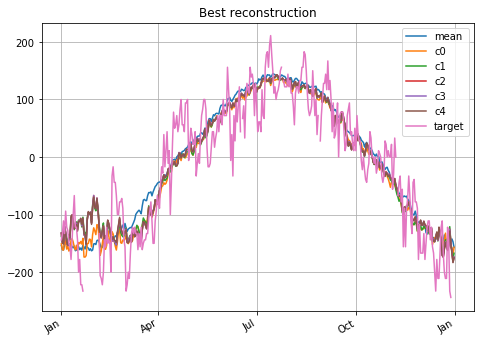

In [39]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [20]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row,Mean,v)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

TypeError: decompose() takes exactly 1 argument (3 given)

In [19]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [21]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 2254
after filter 2254


In [22]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [26]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=3, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [27]:
df3=df3.sort(df3.res_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+------------------+------------------+------------------+
|           res_mean|             res_1|             res_2|             res_3|
+-------------------+------------------+------------------+------------------+
|0.25378544924937685|0.7180489696423019|0.6269003594244658|0.5416402233338126|
|0.37071527038946595| 0.990713490838994|0.5852069527363719| 0.574338903212709|
| 0.3094942263090827|0.8091195713364299|  0.74014369787943|0.5885137087316954|
| 0.2100330276930472|0.7714668744393283|0.7150018310655083|0.6060447976314066|
+-------------------+------------------+------------------+------------------+
only showing top 4 rows



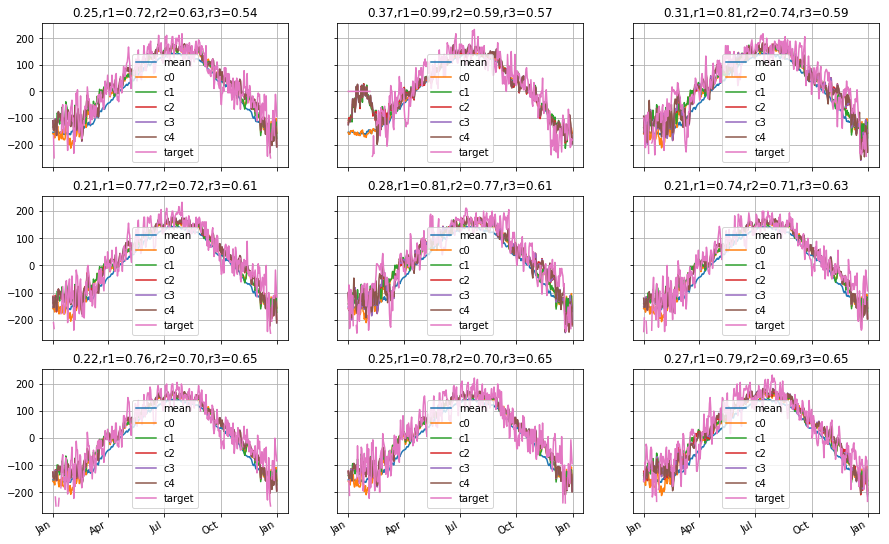

In [28]:
plot_recon_grid(rows)

In [29]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+------------------+------------------+------------------+
|           res_mean|             res_1|             res_2|             res_3|
+-------------------+------------------+------------------+------------------+
|0.17543080250823223| 1.001920666873105|1.3407699817957992|1.3221780168329444|
| 0.1441906768637142|1.0023681695339854|1.2947831626894506| 1.314466516803149|
|0.16028222750623938|0.9994221980409228|1.3233939246945545|1.2892264271427627|
|0.16477271592568965|0.9919250329762471| 1.296936674997068|1.2854640327833229|
+-------------------+------------------+------------------+------------------+
only showing top 4 rows



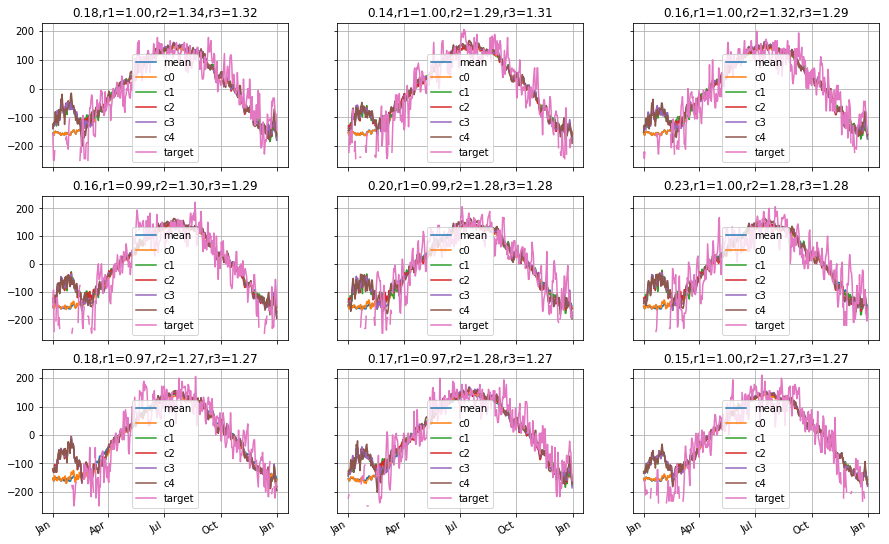

In [30]:
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

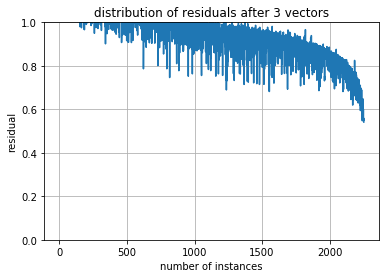

In [31]:
res3=df3.select('res_5').collect()
R3=[r['res_5'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [33]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    #vals=[vals[0]]+vals
    vals1=map(lambda key: key+vals[0], vals)
    plot(vals1,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()
    #plot(vals,P)

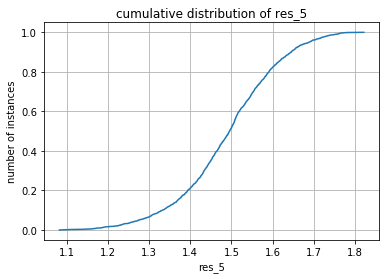

In [34]:
plot_CDF('res_5')

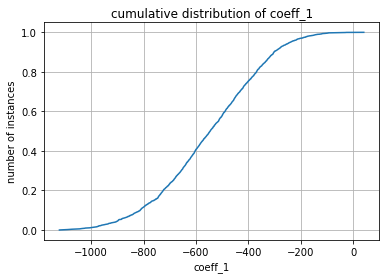

In [35]:
plot_CDF('coeff_1')

In [ ]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [ ]:
!du -sh $data_dir/*.parquet